# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 1179.940667
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 729.330196 analytic: 729.330161, relative error: 2.406963e-08
numerical: -822.267561 analytic: -822.267533, relative error: 1.694506e-08
numerical: 453.593242 analytic: 453.593266, relative error: 2.645281e-08
numerical: -650.120565 analytic: -650.120600, relative error: 2.698498e-08
numerical: 785.375045 analytic: 785.375021, relative error: 1.501183e-08
numerical: 516.948518 analytic: 516.948532, relative error: 1.376260e-08
numerical: -2018.749070 analytic: -2018.749077, relative error: 1.777794e-09
numerical: -1325.279007 analytic: -1325.278978, relative error: 1.095389e-08
numerical: 604.029329 analytic: 604.029266, relative error: 5.154960e-08
numerical: 764.132899 analytic: 764.132818, relative error: 5.301129e-08
numerical: -206.481542 analytic: -206.481548, relative error: 1.224952e-08
numerical: 260.821234 analytic: 260.821210, relative error: 4.658363e-08
numerical: -708.453907 analytic: -708.453968, relative error: 4.263200e-08
numerical: -269.880181 analytic: -2

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 1.179941e+03 computed in 0.077042s
vectorized loss: 2.359881e+00 computed in 0.006181s
Loss difference: 1177.580786
Gradient difference: 164058.238224


In [9]:
loss = 0.0
dW = np.zeros_like(W)
num_classes = W.shape[1]
num_train = X_dev.shape[0]
print(dW)
print(dW.shape)
print(num_classes)
print(num_train)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(3073, 10)
10
500


In [12]:
scores = X_dev.dot(W)
print (scores.shape)
print (scores)

(500, 10)
[[-0.0544169   0.07602815 -0.2050445  ..., -0.3062025  -0.23303242
   0.03229881]
 [-0.3637381  -0.28536441  0.45279466 ..., -0.36134567 -0.81103549
  -0.1018324 ]
 [ 0.06934057 -0.45824711  0.01639659 ...,  0.17498083 -0.04381121
   0.33124976]
 ..., 
 [-0.21301064 -0.19937023 -0.23604092 ..., -0.41097278 -0.32849981
   0.29357166]
 [ 0.42868076  0.09685238  0.28009359 ...,  0.60161593  0.06934941
   0.00324997]
 [ 0.193847    0.34714942 -0.03852985 ..., -0.33441021  0.23773938
  -0.245807  ]]


In [13]:
scores = np.exp(scores)
print (scores)

[[ 0.9470372   1.07899295  0.81461107 ...,  0.73623752  0.79212789
   1.03282608]
 [ 0.69507321  0.75174026  1.57270122 ...,  0.69673811  0.44439766
   0.90318091]
 [ 1.07180117  0.63239118  1.01653175 ...,  1.19122339  0.95713464
   1.39270759]
 ..., 
 [ 0.80814754  0.81924652  0.78974836 ...,  0.66300498  0.72000306
   1.34120929]
 [ 1.53523084  1.10169772  1.32325364 ...,  1.8250656   1.07181064
   1.00325526]
 [ 1.21391054  1.41502814  0.96220299 ...,  0.71576011  1.26837859
   0.78207315]]


In [15]:
scores_sums = np.sum(scores, axis=1)
print (scores_sums.shape)
print (scores_sums)

(500,)
[ 10.12440693   9.97675979  10.14167502  11.55285122   8.86635349
   9.37343039   8.94427171  10.81509473  13.53834941  12.1040548
  12.49273995  10.87628154  12.47979745  11.84122112  12.82914486
   9.33399255  11.31866095   9.27063423  10.16522058  11.91998363
  10.08474939  12.27114677   9.05655172  11.43011177  11.10169314
  10.84124872  13.6430145   10.41058593  10.25988027   9.66018003
   9.56452555  10.41789484  11.25372     11.43720217   9.96745119
   8.85266548  12.35453025  12.83996953  10.1880503    9.81966929
  11.03671155  11.09679769  10.16730535  10.47059251  10.7740201
   9.95216835  10.54387056   9.93934558  10.66179418  11.10332083
   9.42566583  10.08654581  10.11009935  10.76857224   9.60533532
  10.21574992   8.77452179  12.12077809  12.18912377  10.27895394
  12.19084641  11.13077292   9.22829649   9.28935562   9.92507216
  11.39330929  10.88846554  10.3453253   11.42830753  10.72206789
  10.55155384  10.30174703  11.42966412  10.27733916   9.64336606
  10.

In [16]:
y_dev

array([7, 1, 2, 7, 5, 3, 0, 3, 7, 7, 7, 3, 1, 0, 4, 1, 6, 5, 2, 4, 3, 2, 0,
       4, 2, 6, 0, 8, 3, 3, 7, 3, 6, 4, 8, 9, 0, 9, 3, 8, 2, 6, 9, 3, 2, 9,
       2, 7, 7, 8, 8, 2, 9, 3, 8, 6, 8, 1, 1, 7, 6, 6, 8, 1, 5, 9, 0, 1, 7,
       1, 4, 7, 5, 5, 5, 7, 1, 2, 5, 8, 3, 1, 0, 3, 9, 0, 8, 1, 4, 7, 4, 0,
       7, 2, 2, 8, 2, 2, 5, 4, 0, 1, 0, 1, 9, 2, 0, 6, 6, 2, 2, 1, 7, 3, 8,
       4, 4, 1, 0, 8, 5, 9, 1, 5, 7, 1, 1, 9, 9, 5, 2, 7, 6, 9, 8, 5, 6, 5,
       8, 7, 6, 8, 3, 4, 5, 4, 9, 7, 8, 9, 7, 5, 5, 5, 3, 4, 2, 4, 5, 4, 1,
       3, 7, 6, 8, 5, 6, 4, 2, 2, 3, 5, 7, 0, 8, 7, 2, 0, 8, 4, 8, 6, 5, 0,
       9, 7, 5, 9, 3, 3, 3, 0, 5, 7, 4, 2, 9, 1, 2, 1, 1, 0, 9, 8, 1, 4, 0,
       5, 3, 3, 7, 9, 1, 2, 4, 1, 9, 2, 0, 4, 1, 1, 0, 5, 6, 1, 7, 3, 3, 4,
       8, 7, 9, 2, 3, 5, 3, 1, 9, 8, 4, 8, 0, 7, 4, 0, 6, 7, 2, 4, 1, 7, 3,
       0, 4, 5, 4, 7, 4, 8, 3, 8, 4, 1, 9, 2, 5, 2, 8, 1, 5, 3, 5, 3, 7, 2,
       3, 4, 4, 8, 5, 7, 1, 8, 8, 9, 8, 7, 2, 4, 9, 4, 5, 2, 5, 5, 6, 8, 1,
       8, 2,

In [17]:
cors = scores[range(num_train), y_dev]
print (cors)

[ 0.73623752  0.75174026  1.01653175  1.18271886  1.04156532  0.75506583
  0.47215318  0.84470219  1.99607364  1.07145313  1.11344941  0.68182815
  2.12776067  1.29628799  0.91909309  1.13868293  0.8193057   0.55138638
  1.31889692  1.21078817  0.87570827  1.24247968  0.92343229  1.50819758
  1.55490853  0.98039244  1.61028419  0.73318286  0.93258305  0.82637429
  1.1305814   1.01067252  0.60511651  2.21580023  0.81668503  0.9647501
  1.70649514  0.7604527   1.01202263  0.72874241  0.88750756  1.22256502
  0.72329973  0.7513649   1.1985244   0.63131329  0.83210522  0.86151438
  1.35366174  1.29916117  0.93855277  0.96275978  1.12002219  1.19930912
  1.31096733  1.29986488  0.81627729  1.54620855  1.12693077  0.85269699
  1.83567906  1.17027655  1.06382057  1.08994885  0.89232141  0.79221116
  1.29538862  0.90810258  1.11417748  0.98379281  0.75232102  1.57315626
  1.49607944  0.74763648  1.21056176  0.97712167  0.64308868  1.20075861
  1.39649299  1.05707377  1.07614572  0.82027221  0.

In [19]:
print (cors.shape)

(500,)


In [21]:
loss = cors / scores_sums
print (loss.shape)
print (loss)

(500,)
[ 0.07271908  0.07534914  0.10023312  0.10237463  0.11747392  0.08055384
  0.05278833  0.078104    0.14743848  0.08852018  0.08912772  0.06268945
  0.17049641  0.10947249  0.07164103  0.12199313  0.07238539  0.05947666
  0.12974602  0.10157633  0.08683491  0.10125212  0.1019629   0.1319495
  0.14006049  0.09043169  0.11802994  0.07042667  0.09089609  0.0855444
  0.1182057   0.09701312  0.05377035  0.19373621  0.08193519  0.10897849
  0.13812708  0.05922543  0.09933428  0.07421252  0.08041413  0.11017278
  0.07113977  0.07175954  0.11124208  0.06343475  0.07891838  0.08667717
  0.12696378  0.11700654  0.09957416  0.0954499   0.11078251  0.11137123
  0.13648324  0.12724126  0.09302812  0.12756677  0.0924538   0.08295562
  0.15057847  0.10513884  0.11527811  0.1173331   0.08990579  0.06953302
  0.11896889  0.08777903  0.09749278  0.09175402  0.07129955  0.15270772
  0.13089444  0.07274611  0.12553311  0.08981161  0.07221445  0.08628931
  0.12566135  0.12091823  0.09052654  0.089078

In [25]:
loss = -np.sum(np.log(loss))/num_train + 0.000005 * np.sum(W*W)
print (loss)

2.35988133577


In [30]:
scores_sums.reshape(num_train, 1).shape

(500, 1)

In [34]:
s = np.divide(scores, scores_sums.reshape(num_train,1))
print (s)
print (s.shape)
s[range(num_train), y_dev]

[[ 0.09354002  0.10657345  0.08046013 ...,  0.07271908  0.07823944
   0.10201349]
 [ 0.06966923  0.07534914  0.15763647 ...,  0.06983611  0.04454329
   0.09052848]
 [ 0.10568285  0.06235569  0.10023312 ...,  0.11745825  0.09437639
   0.1373252 ]
 ..., 
 [ 0.08317107  0.08431333  0.0812775  ...,  0.06823362  0.07409962
   0.13803149]
 [ 0.12542556  0.09000669  0.10810741 ...,  0.14910453  0.08756497
   0.08196412]
 [ 0.12212373  0.14235688  0.09680106 ...,  0.07200802  0.12760341
   0.07867935]]
(500, 10)


array([ 0.07271908,  0.07534914,  0.10023312,  0.10237463,  0.11747392,
        0.08055384,  0.05278833,  0.078104  ,  0.14743848,  0.08852018,
        0.08912772,  0.06268945,  0.17049641,  0.10947249,  0.07164103,
        0.12199313,  0.07238539,  0.05947666,  0.12974602,  0.10157633,
        0.08683491,  0.10125212,  0.1019629 ,  0.1319495 ,  0.14006049,
        0.09043169,  0.11802994,  0.07042667,  0.09089609,  0.0855444 ,
        0.1182057 ,  0.09701312,  0.05377035,  0.19373621,  0.08193519,
        0.10897849,  0.13812708,  0.05922543,  0.09933428,  0.07421252,
        0.08041413,  0.11017278,  0.07113977,  0.07175954,  0.11124208,
        0.06343475,  0.07891838,  0.08667717,  0.12696378,  0.11700654,
        0.09957416,  0.0954499 ,  0.11078251,  0.11137123,  0.13648324,
        0.12724126,  0.09302812,  0.12756677,  0.0924538 ,  0.08295562,
        0.15057847,  0.10513884,  0.11527811,  0.1173331 ,  0.08990579,
        0.06953302,  0.11896889,  0.08777903,  0.09749278,  0.09

In [ ]:
# grad
  s = np.divide(scores, scores_sums.reshape(num_train,1))
  s[range(num_train), y] =- (scores_sums - cors) / scores_sums
  dW = X.T.dot(s)
  dW /= num_train
  dW += 2 * reg * W

In [ ]:
 scores -= scores.max()
  scores = np.exp(scores)
  scores_sums = np.sum(scores, axis=1)
  cors = scores[range(num_train), y]
  loss = cors / scores_sums
  loss = -np.sum(np.log(loss))/num_train + reg * np.sum(W*W)


In [ ]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)
  num_classes = W.shape[1]
  num_train = X.shape[0]

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  scores = X.dot(W)
  scores -= scores.max()
  scores = np.exp(scores)
  scores_sums = np.sum(scores, axis=1)
  cors = scores[range(num_train), y]
  loss = cors / scores_sums
  loss = -np.sum(np.log(loss))/num_train + reg * np.sum(W*W)

  # grad
  s = np.divide(scores, scores_sums.reshape(num_train,1))
  s[range(num_train), y] =- (scores_sums - cors) / scores_sums
  dW = X.T.dot(s)
  dW /= num_train
  dW += 2 * reg * W
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

In [35]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
softmax = Softmax()

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500)
        
        y_train_pred = softmax.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        
        y_val_pred = softmax.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (acc_train, acc_val)
        
        if acc_val > best_val:
            best_val = acc_val
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.330796 val accuracy: 0.342000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.312265 val accuracy: 0.328000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.322490 val accuracy: 0.338000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.302061 val accuracy: 0.316000
best validation accuracy achieved during cross-validation: 0.342000


In [36]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.312000


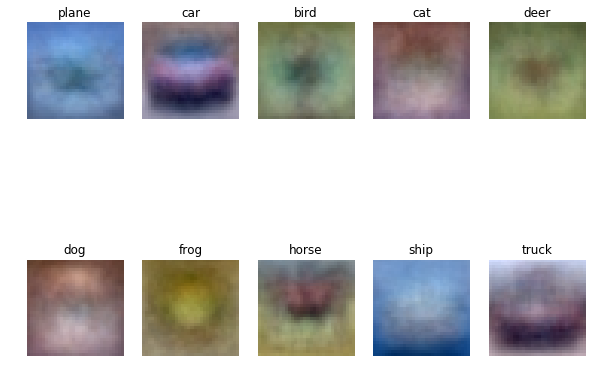

In [37]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])